## Run Comparison

### Objective
This notebook is designed to compare runtime and price performance of various Serverless and DPGCE runs.

### Initialize Project and Region

In [1]:
import requests
import json
import os
import subprocess

# Retrieves the current region in use
def get_gcloud_region():
    metadata_url = "http://metadata.google.internal/computeMetadata/v1/instance/zone"
    headers = {"Metadata-Flavor": "Google"}

    try:
        response = requests.get(metadata_url, headers=headers, timeout=5)
        response.raise_for_status() 
        zone = response.text.split('/')[-1]
        region = '-'.join(zone.split('-')[:-1])
        return region
    except requests.exceptions.RequestException as e:
        print(f"Could not retrieve region from metadata server: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None
    
# Returns name of current project
def get_gcloud_project():
    try:
        command = ["gcloud", "config", "get", "project"]
        process = subprocess.run(command, capture_output=True, text=True, check=True)
        project_name = process.stdout.strip()
        return project_name
    except subprocess.CalledProcessError as e:
        raise ValueError(f"Error getting gcloud project: {e}\nStdout: {e.stdout}\nStderr: {e.stderr}")
    except FileNotFoundError:
        raise ValueError("Error: gcloud command not found. Make sure the Google Cloud CLI is installed and in your system's PATH.")
        
# Returns project number of current project
def get_project_number(project_id: str) -> str:
    try:
        command = [
            "gcloud",
            "projects",
            "describe",
            project_id,
            "--format=value(projectNumber)",
        ]
        result = subprocess.run(command, capture_output=True, text=True, check=True)
        project_number = result.stdout.strip()
        return project_number
    except subprocess.CalledProcessError as e:
        raise ValueError(f"Error executing gcloud command for project ID '{project_id}': {e}\nStderr: {e.stderr}")
    except FileNotFoundError:
        raise ValueError("Error: gcloud CLI not found. Make sure it's installed and in your system's PATH.")

REGION = get_gcloud_region()
PROJECT = get_gcloud_project()
PROJECT_NUMBER = get_project_number(PROJECT)

print(f"Google Cloud Project: {PROJECT}")
print(f"Project Number: {PROJECT_NUMBER}")
print(f"Region: {REGION}")

Google Cloud Project: nishitkamdarargo
Project Number: 279814974066
Region: us-east1


### Initialize default bucket and cluster names

In [2]:
DPGCE_STANDARD_BUCKET_PREFIX = f"sparkpoc-bucket-dpgce-standard-{PROJECT_NUMBER}"
DPGCE_PREMIUM_BUCKET_PREFIX = f"sparkpoc-bucket-dpgce-premium-{PROJECT_NUMBER}"
SERVERLESS_STANDARD_BUCKET_PREFIX = f"sparkpoc-bucket-serverless-standard-{PROJECT_NUMBER}"
SERVERLESS_PREMIUM_BUCKET_PREFIX = f"sparkpoc-bucket-serverless-premium-{PROJECT_NUMBER}"
SERVERLESS_PREMIUM__WITH_NQE_BUCKET_PREFIX = f"sparkpoc-bucket-serverless-premium-nqe-{PROJECT_NUMBER}"

DEFAULT_DPGCE_STANDARD_CLUSTER = "dpgce-benchmarking-standard"
DEFAULT_DPGCE_PREMIUM_CLUSTER = "dpgce-benchmarking-premium-2"

### Override Default Configuration

**Specify Result Location and Cluster names** : Bucket and cluster names are pre-initialized with defaults. If you used custom bucket/cluster name during benchmark runs, provide the applicable offering's bucket/cluster name here. Refer to the output of the `Initialize your GCS Bucket cell` for the correct path. For the sake of simplicity it is advised to use the default names.


**Run ID Selection** :

- Automatic: Based on the bucket names provided, the system will automatically fetch and use the latest Run ID from each corresponding bucket (if it exists).


- Manual: To analyze a custom set of runs, update the cell titled `Initialize the List of Run Ids`. Here, you can add or remove specific Run IDs to the default list. Make sure 


In [3]:
comparison_requirements = {
    "dpgce_standard_bucket": "", 
    "dpgce_premium_bucket": "",
    "serverless_standard_spark_bucket":"",
    "serverless_premium_native_bucket": "",
    "serverless_premium_spark_bucket": "",
    "dpgce_standard_cluster": "", 
    "dpgce_premium_cluster": ""
}

### Getting latest Run IDs

In [4]:
import subprocess
import os
from google.cloud import storage
from typing import Tuple
from datetime import datetime

latest_dpgce_standard_id = None
latest_dpgce_premium_id = None
latest_serverless_standard_spark_id = None
latest_serverless_premium_with_nqe_id = None
latest_serverless_premium_spark_id = None

# Get the latest Run Ids
def initialize_default_ids(comparison_requirements: dict):
    global latest_dpgce_standard_id
    global latest_dpgce_premium_id
    global latest_dpgce_premium_with_nqe_id
    global latest_serverless_standard_spark_id
    global latest_serverless_premium_with_nqe_id
    global latest_serverless_premium_spark_id
    
    try:
        serverless_standard_spark_bucket = SERVERLESS_STANDARD_BUCKET_PREFIX + "-" + REGION if comparison_requirements.get("serverless_standard_spark_bucket","") == "" else comparison_requirements.get("serverless_standard_spark_bucket","") 
        serverless_premium_native_bucket = SERVERLESS_PREMIUM__WITH_NQE_BUCKET_PREFIX + "-" + REGION if comparison_requirements.get("serverless_premium_native_bucket","") == "" else comparison_requirements.get("serverless_premium_native_bucket","") 
        serverless_premium_spark_bucket = SERVERLESS_PREMIUM_BUCKET_PREFIX + "-" + REGION if comparison_requirements.get("serverless_premium_spark_bucket","") == "" else comparison_requirements.get("serverless_premium_spark_bucket","") 
        dpgce_standard_bucket = DPGCE_STANDARD_BUCKET_PREFIX + "-" + REGION if comparison_requirements.get("dpgce_standard_bucket","") == "" else comparison_requirements.get("dpgce_standard_bucket","") 
        dpgce_premium_bucket = DPGCE_PREMIUM_BUCKET_PREFIX + "-" + REGION if comparison_requirements.get("dpgce_premium_bucket","") == "" else comparison_requirements.get("dpgce_premium_bucket","") 
        dpgce_standard_cluster = DEFAULT_DPGCE_STANDARD_CLUSTER if comparison_requirements.get("dpgce_standard_cluster","") == "" else comparison_requirements.get("dpgce_standard_cluster","") 
        dpgce_premium_cluster = DEFAULT_DPGCE_PREMIUM_CLUSTER if comparison_requirements.get("dpgce_premium_cluster","") == "" else comparison_requirements.get("dpgce_premium_cluster","") 
        
        folder_path = f"{dpgce_standard_cluster}/standard/spark/output/"
        latest_dpgce_standard_id = get_latest_run_id_from_gcs(dpgce_standard_bucket,folder_path)
                
        folder_path = f"{dpgce_premium_cluster}/premium/spark/output/"
        latest_dpgce_premium_id = get_latest_run_id_from_gcs(dpgce_premium_bucket,folder_path)

        folder_path = f"{dpgce_premium_cluster}/premium/native/output/"
        latest_dpgce_premium_with_nqe_id = get_latest_run_id_from_gcs(dpgce_premium_bucket,folder_path)

        folder_path = f"standard/spark/output/"
        latest_serverless_standard_spark_id = get_latest_run_id_from_gcs(serverless_standard_spark_bucket,folder_path)

        folder_path = f"premium/native/output/"
        latest_serverless_premium_with_nqe_id = get_latest_run_id_from_gcs(serverless_premium_native_bucket,folder_path)
        
        folder_path = f"premium/spark/output/"
        latest_serverless_premium_spark_id = get_latest_run_id_from_gcs(serverless_premium_spark_bucket,folder_path)
        
    except Exception as e:
        print(f"Error getting latest files : {e}") 

# Get the latest Run Id from a given GCS path        
def get_latest_run_id_from_gcs(bucket_name: str, folder_path: str) -> str | None:
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)

    try:
        if not bucket.exists(): # Explicit check for bucket existence
            print(f"GCS bucket '{bucket_name}' not found or inaccessible. \n")
            return None

        blobs = list(bucket.list_blobs(prefix=folder_path))

    except Exception as e:
        print(f"An unexpected error occurred while accessing GCS: {e} \n")
        return None

    if not blobs:
        print(f"No objects found with given GCS path as prefix: gs://{bucket_name}/{folder_path} \n")
        return None
    
   
    latest_blob = max(blobs, key=lambda blob: blob.time_created)
    base_name = os.path.basename(latest_blob.name)
    print(f"base_name: {base_name}")
    run_id = os.path.splitext(base_name)[0]
    print(f"run_id: {run_id}")
    
    return run_id


# Initializing the latest run ids
initialize_default_ids(comparison_requirements)

print("Default Run Ids from latest runs : ")
print(f"DPGCE Standard: {latest_dpgce_standard_id}")
print(f"DPGCE Premium (with Lightning Engine): {latest_dpgce_premium_id}")
print(f"DPGCE Premium (with Lightning Engine) with NQE: {latest_dpgce_premium_with_nqe_id}")
print(f"Serverless Standard: {latest_serverless_standard_spark_id}")
print(f"Serverless Premium with NQE: {latest_serverless_premium_with_nqe_id}")
print(f"Serverless Premium: {latest_serverless_premium_spark_id}")



latest_blob: <Blob: sparkpoc-bucket-dpgce-standard-279814974066-us-east1, dpgce-benchmarking-standard/standard/spark/output/parquet/tpcds/sf1000/dpgce_standard_spark_parquet_sf1000_tpch_tpcds_dpgce-benchmarking-standard_us-east1_2025-08-05_10-50-14.csv, 1754395100004792>
base_name: dpgce_standard_spark_parquet_sf1000_tpch_tpcds_dpgce-benchmarking-standard_us-east1_2025-08-05_10-50-14.csv
run_id: dpgce_standard_spark_parquet_sf1000_tpch_tpcds_dpgce-benchmarking-standard_us-east1_2025-08-05_10-50-14
latest_blob: <Blob: sparkpoc-bucket-dpgce-premium-279814974066-us-east1, dpgce-benchmarking-premium-2/premium/spark/output/parquet/tpcds/sf1000/dpgce_premium_spark_parquet_sf1000_tpch_tpcds_dpgce-benchmarking-premium-2_us-east1_2025-08-06_09-31-21.csv, 1754476543711747>
base_name: dpgce_premium_spark_parquet_sf1000_tpch_tpcds_dpgce-benchmarking-premium-2_us-east1_2025-08-06_09-31-21.csv
run_id: dpgce_premium_spark_parquet_sf1000_tpch_tpcds_dpgce-benchmarking-premium-2_us-east1_2025-08-06_09-3

### Initialize the List of Run Ids
For runtime and cost performance details, enter the desired Run IDs (limit to 10 for better output readability)

**NOTE - By default, this list is initialized with the Run IDs of the latest runs. Edit, add, or remove Run IDs as needed.**

**Locate the Run ID for a specific run within its notebook output under the title: `Defining the Run Id`**

In [5]:
run_ids = [
        latest_dpgce_standard_id,
        latest_dpgce_premium_id,
        latest_dpgce_premium_with_nqe_id,
        latest_serverless_standard_spark_id,
        latest_serverless_premium_with_nqe_id,
        latest_serverless_premium_spark_id
]

### Utility Functions for Runtime Performance
Load the utility functions required for performance comparison.

In [6]:
import csv
import io
import matplotlib.pyplot as plt
from typing import List, Dict
import re


# Fetches the name of the latest file (by creation time) in a GCS folder
def get_latest_file_from_gcs(bucket_name: str, folder_path: str) -> str or None:
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_path))

    if not blobs:
        return None

    latest_blob = max(blobs, key=lambda blob: blob.time_created)
    return f"gs://{bucket_name}/{latest_blob.name}"

# Checks if the given path is a valid GCS path
def is_valid_gcs_path(gcs_uri: str):
    match = re.match(r"gs://([^/]+)/(.*)", gcs_uri)
    if not match:
        print(f"Invalid GCS URI: {gcs_uri}. The given GCS path does not exist.")
        return False
    return True

# Reads query Ids and runtimes from a GCS CSV file into a dictionary
def read_query_runtimes_from_gcs_csv(gcs_uri: str, header_row_index: int = 0) -> Dict[str, int]:
    storage_client = storage.Client()
    match = re.match(r"gs://([^/]+)/(.*)", gcs_uri)
    bucket_name = match.group(1)
    file_path = match.group(2)
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(file_path)

    try:
        csv_data = blob.download_as_text(encoding="utf-8")
        lines = csv_data.splitlines()

        if header_row_index >= len(lines):
            print(f"Warning: Header row index {header_row_index} is out of bounds for file {gcs_uri}.")
            return {}
        
        header = [h.strip() for h in lines[header_row_index].split(',')]
        reader = csv.DictReader(io.StringIO("\n".join(lines[header_row_index:])), fieldnames=header)
        
        runtimes = {}
        encountered_empty_row = False
        for i, row in enumerate(reader):
            # Skip the header row itself during data processing
            if i == 0:
                continue

            if not any(row.values()):  # Check if all values in the row are empty
                encountered_empty_row = True
                break

            if encountered_empty_row:
                continue

            query_id = row.get("Query_Id")
            runtime_str = row.get("Runtime (in ms)")

            if query_id and runtime_str and runtime_str.isdigit():
                runtimes[query_id] = int(runtime_str)
        return runtimes
    except Exception as e:
        print(f"Error reading CSV from {gcs_uri}: {e}")
        return {}

# Fetches GCS paths corresponding to the given run ids
def get_runtime_file_gcs_path(
    comparison_requirements: dict,
    run_id: str,
    benchmark: str
) -> str or None:
    
    components = run_id.split("_")
    
    if len(components) < 9:
        print(f"Invalid run id {run_id}")
        return None
    
    offering = components[0]
    tier = components[1]
    runtype = components[2]
    file_format = components[3]
    size = components[4]
    combined_offering = offering + "_" + tier + "_" + runtype    
    
    if offering == "dpgce":
        if "tpch" in run_id and "tpcds" in run_id:
            first_benchmark = components[5]
            second_benchmark = components[6]
            region = components[-3]
            cluster_name_parts = components[7:-3]
            cluster_name = "_".join(cluster_name_parts)
            if first_benchmark!=benchmark and second_benchmark!=benchmark:
                print(f"The given run Id {run_id} does not have {benchmark} run.")
                return None   
        else:
            first_benchmark = components[5]
            region = components[-3]
            cluster_name_parts = components[6:-3]
            cluster_name = "_".join(cluster_name_parts)
            if first_benchmark!=benchmark:
                print(f"The given run Id {run_id} does not have {benchmark} run.")
                return None
    
    elif offering == "serverless":
        if len(components) > 10:
            print(f"Invalid run id : {run_id}")
            
        if "tpch" in run_id and "tpcds" in run_id:    
            first_benchmark = components[5]
            second_benchmark = components[6]
            region = components[7]

            if first_benchmark!=benchmark and second_benchmark!=benchmark:
                print(f"The given run Id {run_id} does not have {benchmark} run.")
                return None
        else:
            first_benchmark = components[5]
            region = components[6]
            if first_benchmark!=benchmark:
                print(f"The given run Id {run_id} does not have {benchmark} run.")
                return None
    
    else:
        print(f"Unsupported offering {combined_offering} in {run_id}. \n")
        return None  
    
    if combined_offering == "serverless_standard_spark":
        bucket_name = SERVERLESS_STANDARD_BUCKET_PREFIX + "-" + region if comparison_requirements.get("serverless_standard_spark_bucket","") == "" else comparison_requirements.get("serverless_standard_spark_bucket","")        
        runtime_file_path=f"gs://{bucket_name}/{tier}/{runtype}/output/{file_format}/{benchmark}/{size}/{run_id}.csv"
        return runtime_file_path
        
    elif combined_offering == "serverless_premium_native":
        bucket_name = SERVERLESS_PREMIUM__WITH_NQE_BUCKET_PREFIX + "-" + region if comparison_requirements.get("serverless_premium_native_bucket","") == "" else comparison_requirements.get("serverless_premium_native_bucket","") 
        runtime_file_path=f"gs://{bucket_name}/{tier}/{runtype}/output/{file_format}/{benchmark}/{size}/{run_id}.csv"
        return runtime_file_path
    
    elif combined_offering == "serverless_premium_spark":
        bucket_name = SERVERLESS_PREMIUM_BUCKET_PREFIX + "-" + region if comparison_requirements.get("serverless_premium_spark_bucket","") == "" else comparison_requirements.get("serverless_premium_spark_bucket","") 
        runtime_file_path=f"gs://{bucket_name}/{tier}/{runtype}/output/{file_format}/{benchmark}/{size}/{run_id}.csv"
        return runtime_file_path        
        
    elif combined_offering == "dpgce_standard_spark":
        dpgce_standard_cluster = cluster_name
        bucket_name = DPGCE_STANDARD_BUCKET_PREFIX + "-" + region if comparison_requirements.get("dpgce_standard_bucket","") == "" else comparison_requirements.get("dpgce_standard_bucket","") 
        runtime_file_path = f"gs://{bucket_name}/{dpgce_standard_cluster}/standard/{runtype}/output/{file_format}/{benchmark}/{size}/{run_id}.csv"
        return runtime_file_path
    
    elif combined_offering == "dpgce_premium_spark" or combined_offering == "dpgce_premium_native":
        dpgce_premium_cluster = cluster_name
        bucket_name = DPGCE_PREMIUM_BUCKET_PREFIX + "-" + region if comparison_requirements.get("dpgce_premium_bucket","") == "" else comparison_requirements.get("dpgce_premium_bucket","") 
        runtime_file_path = f"gs://{bucket_name}/{dpgce_premium_cluster}/premium/{runtype}/output/{file_format}/{benchmark}/{size}/{run_id}.csv"
        return runtime_file_path
    
    else:
        print(f"Unsupported combined offering {combined_offering}. \n")
        return None
    
import matplotlib.pyplot as plt
from typing import Dict, List
from tabulate import tabulate
import textwrap

# Plot a graph comparing all the given runtimes
def plot_comparison_runtimes(
    all_runtimes: List[Dict[str,int]],
    benchmark: str,
    filtered_run_id_headers: List[str]
):
    
    plt.figure(figsize=(25, 15))
    all_query_ids = set()
    
    for runtime in all_runtimes:
        all_query_ids = all_query_ids | set(runtime.keys())
            
    sorted_query_ids = sorted(list(all_query_ids))    
    
    rows=[]
    for query_id in sorted_query_ids:
        row=[]
        row.append(query_id)
        for runtime in all_runtimes:
            query_runtime = runtime.get(query_id, "--")
            row.append(query_runtime)
        rows.append(row)
    
    # To exclude this in the graph for better visibility
    sorted_query_ids.remove("Sum")
    
    wrap_width = 10  # Adjust this value as needed

    wrapped_headers = [
        "\n".join(textwrap.wrap(header, width=wrap_width))
        for header in filtered_run_id_headers
    ]
    
    print()
    print("-------------------------------------------------- Summary --------------------------------------------------")
    print(tabulate(rows, headers=wrapped_headers, tablefmt="fancy_grid"))
    print()
    print()
    
    for i, run_data in enumerate(all_runtimes):
        runtime_values = [run_data.get(q_id, None) for q_id in sorted_query_ids]
        plt.plot(sorted_query_ids, runtime_values, marker='o', linestyle='-', label=filtered_run_id_headers[i])

    plt.xlabel("Query Id", fontsize=20)
    plt.ylabel("Runtime (in seconds)", fontsize=20)
    plt.title(f"Query Runtimes Comparison for {benchmark}", fontsize=25)
    plt.xticks(rotation=90, ha='right', fontsize=15)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.grid(True)
    plt.tight_layout()
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()

# Processes the runtime files to read query wise runtimes
def process_runtime_files(
    runtime_file_paths: List[str],
    run_Id_headers: List[str]
) -> Tuple[List[Dict[str,int]] , List[str]]:
    
    all_runtimes = []
    filtered_run_id_headers = []
    for index, path in enumerate(runtime_file_paths):
        if is_valid_gcs_path(path):
            print(f"  \nReading runtimes from: {path}")
            header_row_index=0
            if "dpgce" in path:
                header_row_index=1  
            try:
                runtimes = read_query_runtimes_from_gcs_csv(path,header_row_index)
                all_runtimes.append(runtimes)
                filtered_run_id_headers.append(run_Id_headers[index])
            except Exception as e:
                print(f"  Error processing file '{path}': {e}")
                print("   Skipping this file' \n")
        else:
            print(f"  Warning: Invalid GCS path {path}, skipping this file. \n")
    
    return all_runtimes, filtered_run_id_headers

#  Displays a comparison of the runtimes for the given Run IDs    
def compare_runtimes(
    comparison_requirements: dict,
    run_ids: List[str],
    benchmark: str
):
    run_id_headers = []
    filepaths = []
    for run_id in run_ids:
        if run_id is None or run_id == "":
            continue
        filepath = get_runtime_file_gcs_path(comparison_requirements,run_id,benchmark)
        if filepath is None:
            print(f"File with {benchmark} runtimes was not found for run id : {run_id}. Skipping this Run Id.")
            continue
        filepaths.append(filepath)
        run_id_headers.append(run_id)
    
    all_runtimes,filtered_run_id_headers = process_runtime_files(filepaths,run_id_headers)
    plot_comparison_runtimes(all_runtimes,benchmark,filtered_run_id_headers)

### Utility Functions for Cost Performance
Load the utility functions required for cost comparison.

In [7]:
import json
from google.cloud import storage
import re
import io

# Get session name from given GCS path
def read_session_name_from_gcs_json(gcs_uri: str) -> str or None:
    storage_client = storage.Client()
    match = re.match(r"gs://([^/]+)/(.*)", gcs_uri)
    if not match:
        print(f"Invalid GCS URI: {gcs_uri}. The given GCS path does not exist. \n")
        return None
    bucket_name = match.group(1)
    file_path = match.group(2)
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(file_path)

    try:
        json_data = blob.download_as_text(encoding="utf-8")
        data = json.loads(json_data)
        if 'name' in data:
            return data['name']
        else:
            print(f"Field name not found in JSON from {gcs_uri}")
            return None
    except json.JSONDecodeError:
        print(f"Error decoding JSON from {gcs_uri}")
        return None
    except Exception as e:
        print(f"Error reading JSON from {gcs_uri}: {e}")
        return None

import subprocess
import time
from typing import Optional, Tuple

# Returns DCU usage and Shuffle Storage usage for a given session
def get_session_usage_with_retry(
    session_name: str, timeout_seconds: int = 480, poll_interval_seconds: int = 15
) -> Optional[Tuple[Optional[int], Optional[int]]]:
    
    start_time = time.time()
    milli_dcu: Optional[int] = None
    shuffle_storage: Optional[int] = None

    while time.time() - start_time < timeout_seconds:
        try:
            command = [
                "gcloud",
                "beta",
                "dataproc",
                "sessions",
                "describe",
                session_name,
                "--format",
                "value(runtimeInfo.approximateUsage)",
            ]
            process = subprocess.run(command, capture_output=True, text=True, check=True)
            output = process.stdout.strip()

            if output:
                parts = output.split(';')
                for part in parts:
                    if "milliDcuSeconds=" in part:
                        try:
                            milli_dcu = int(part.split('=')[1])
                        except ValueError:
                            print(f"Warning: Could not parse milliDcuSeconds: '{part}'")
                    elif "shuffleStorageGbSeconds=" in part:
                        try:
                            shuffle_storage = int(part.split('=')[1])
                        except ValueError:
                            print(f"Warning: Could not parse shuffleStorageGbSeconds: '{part}'")

                if milli_dcu is not None and shuffle_storage is not None:
                    # Converting units from Milli DCU Seconds to DCU hours
                    milli_dcu/=3600000
                    milli_dcu=round(milli_dcu,3)
                    # Converting units from Shuffle Storage GB Seconds to Shuffle Storage GB-months
                    shuffle_storage/=2592000
                    shuffle_storage=round(shuffle_storage,3)
                    return milli_dcu, shuffle_storage

            print(f"Waiting for usage data, it might take some time to reflect... (Elapsed: {int(time.time() - start_time)}/{timeout_seconds} seconds)")
            time.sleep(poll_interval_seconds)

        except subprocess.CalledProcessError as e:
            print(f"Error running gcloud command: {e}")
            print(f"Stderr: {e.stderr}")
            time.sleep(poll_interval_seconds)
        except FileNotFoundError:
            print("Error: gcloud command not found. Make sure the Google Cloud CLI is installed and in your system's PATH.")
            return None, None
        except Exception as e:
            print(f"An unexpected error occurred: {e}")
            time.sleep(poll_interval_seconds)

    print(f"Timeout reached ({timeout_seconds} seconds). Could not retrieve both usage values.")
    return None, None

# Displays the usage metrics for a given Run Id
def evaluate_cost_metrics(
    run_id: str,
    gcs_path: str
):
    session_name = read_session_name_from_gcs_json(gcs_path)
    
    if not session_name:
        print("No session name found. Cannot fetch cost metrics.")
        return
    
    dcu_hours, shuffle_gb = get_session_usage_with_retry(session_name)
    
    if dcu_hours is not None and shuffle_gb is not None:
        print("----------------------------------------------------------------------------------------------------------------")
        print(f"Cost Metrics for Run Id {run_id}")
        print("----------------------------------------------------------------------------------------------------------------")

        print(f"DCU Usage : {dcu_hours} DCU-hours")
        print(f"Shuffle Storage Usage : {shuffle_gb} GB-months")
        print("For pricing details check : https://cloud.google.com/dataproc-serverless/pricing ")

    else:
        print(f"Could not reliably retrieve both usage values for session '{session_name}'.")


# Returns the GCS path of the session file for a given Run Id        
def get_session_file(
    comparison_requirements: dict,
    run_id : str
) -> str or None:
    components = run_id.split("_")


    if len(components) < 9 or len(components) > 10:
        print(f"Invalid run id {run_id}")
        return None
    else:
        offering = components[0]
        tier = components[1]
        runtype = components[2]
        file_format = components[3]
        size = components[4]
        combined_offering = offering + "_" + tier + "_" + runtype
            
        if "tpch" in run_id and "tpcds" in run_id:    
            first_benchmark = components[5]
            second_benchmark = components[6]
            region = components[7]
            
        else:
            first_benchmark = components[5]
            region = components[6]       
        
    if combined_offering == "serverless_standard_spark":
        bucket_name = SERVERLESS_STANDARD_BUCKET_PREFIX + "-" + region if comparison_requirements.get("serverless_standard_spark_bucket","") == "" else comparison_requirements.get("serverless_standard_spark_bucket","") 
    elif combined_offering == "serverless_premium_native":
        bucket_name = SERVERLESS_PREMIUM__WITH_NQE_BUCKET_PREFIX + "-" + region if comparison_requirements.get("serverless_premium_native_bucket","") == "" else comparison_requirements.get("serverless_premium_native_bucket","") 
    elif combined_offering == "serverless_premium_spark":
        bucket_name = SERVERLESS_PREMIUM_BUCKET_PREFIX + "-" + region if comparison_requirements.get("serverless_premium_spark_bucket","") == "" else comparison_requirements.get("serverless_premium_spark_bucket","") 
    else:
        print(f"Unsupported offering {combined_offering} in {run_id}")
            
    session_file_path = f"gs://{bucket_name}/{tier}/serverless_{runtype}_session/{file_format}/{size}/{run_id}.json"  
    
    return session_file_path

# Displays the cost metrics for all the runs in the list of given Run Ids
def compare_cost_metrics(
    comparison_requirements: dict, 
    run_ids: List[str]
):
    for run_id in run_ids:
        print("\n")
        if run_id is None or run_id == "":
            print("Empty Run Id. Skipping it.")
            continue
            
        elif "dpgce" in run_id:
            print(f"Run Id {run_id} is a DPGCE run.")
            print("Pricing details for DPGCE runs can be checked through : https://cloud.google.com/products/calculator")
            continue
            
        gcs_path = get_session_file(comparison_requirements, run_id)
        if gcs_path is None:
            print(f"No session file found for the given Run Id {run_id}. Skipping it.")
            continue
        evaluate_cost_metrics(run_id, gcs_path)

### Compare Runtime Performance

The following cell compares runtimes of all the runs specified in the list of Run Ids.

#### TPCH

  
Reading runtimes from: gs://sparkpoc-bucket-dpgce-standard-279814974066-us-east1/dpgce-benchmarking-standard/standard/spark/output/parquet/tpch/sf1000/dpgce_standard_spark_parquet_sf1000_tpch_tpcds_dpgce-benchmarking-standard_us-east1_2025-08-05_10-50-14.csv
  
Reading runtimes from: gs://sparkpoc-bucket-dpgce-premium-279814974066-us-east1/dpgce-benchmarking-premium-2/premium/spark/output/parquet/tpch/sf1000/dpgce_premium_spark_parquet_sf1000_tpch_tpcds_dpgce-benchmarking-premium-2_us-east1_2025-08-06_09-31-21.csv
  
Reading runtimes from: gs://sparkpoc-bucket-dpgce-premium-279814974066-us-east1/dpgce-benchmarking-premium-2/premium/native/output/parquet/tpch/sf1000/dpgce_premium_native_parquet_sf1000_tpch_tpcds_dpgce-benchmarking-premium-2_us-east1_2025-08-06_10-35-56.csv
  
Reading runtimes from: gs://sparkpoc-bucket-serverless-standard-279814974066-us-east1/standard/spark/output/parquet/tpch/sf1000/serverless_standard_spark_parquet_sf1000_tpch_tpcds_us-east1_2025-08-07_10-58-21.cs

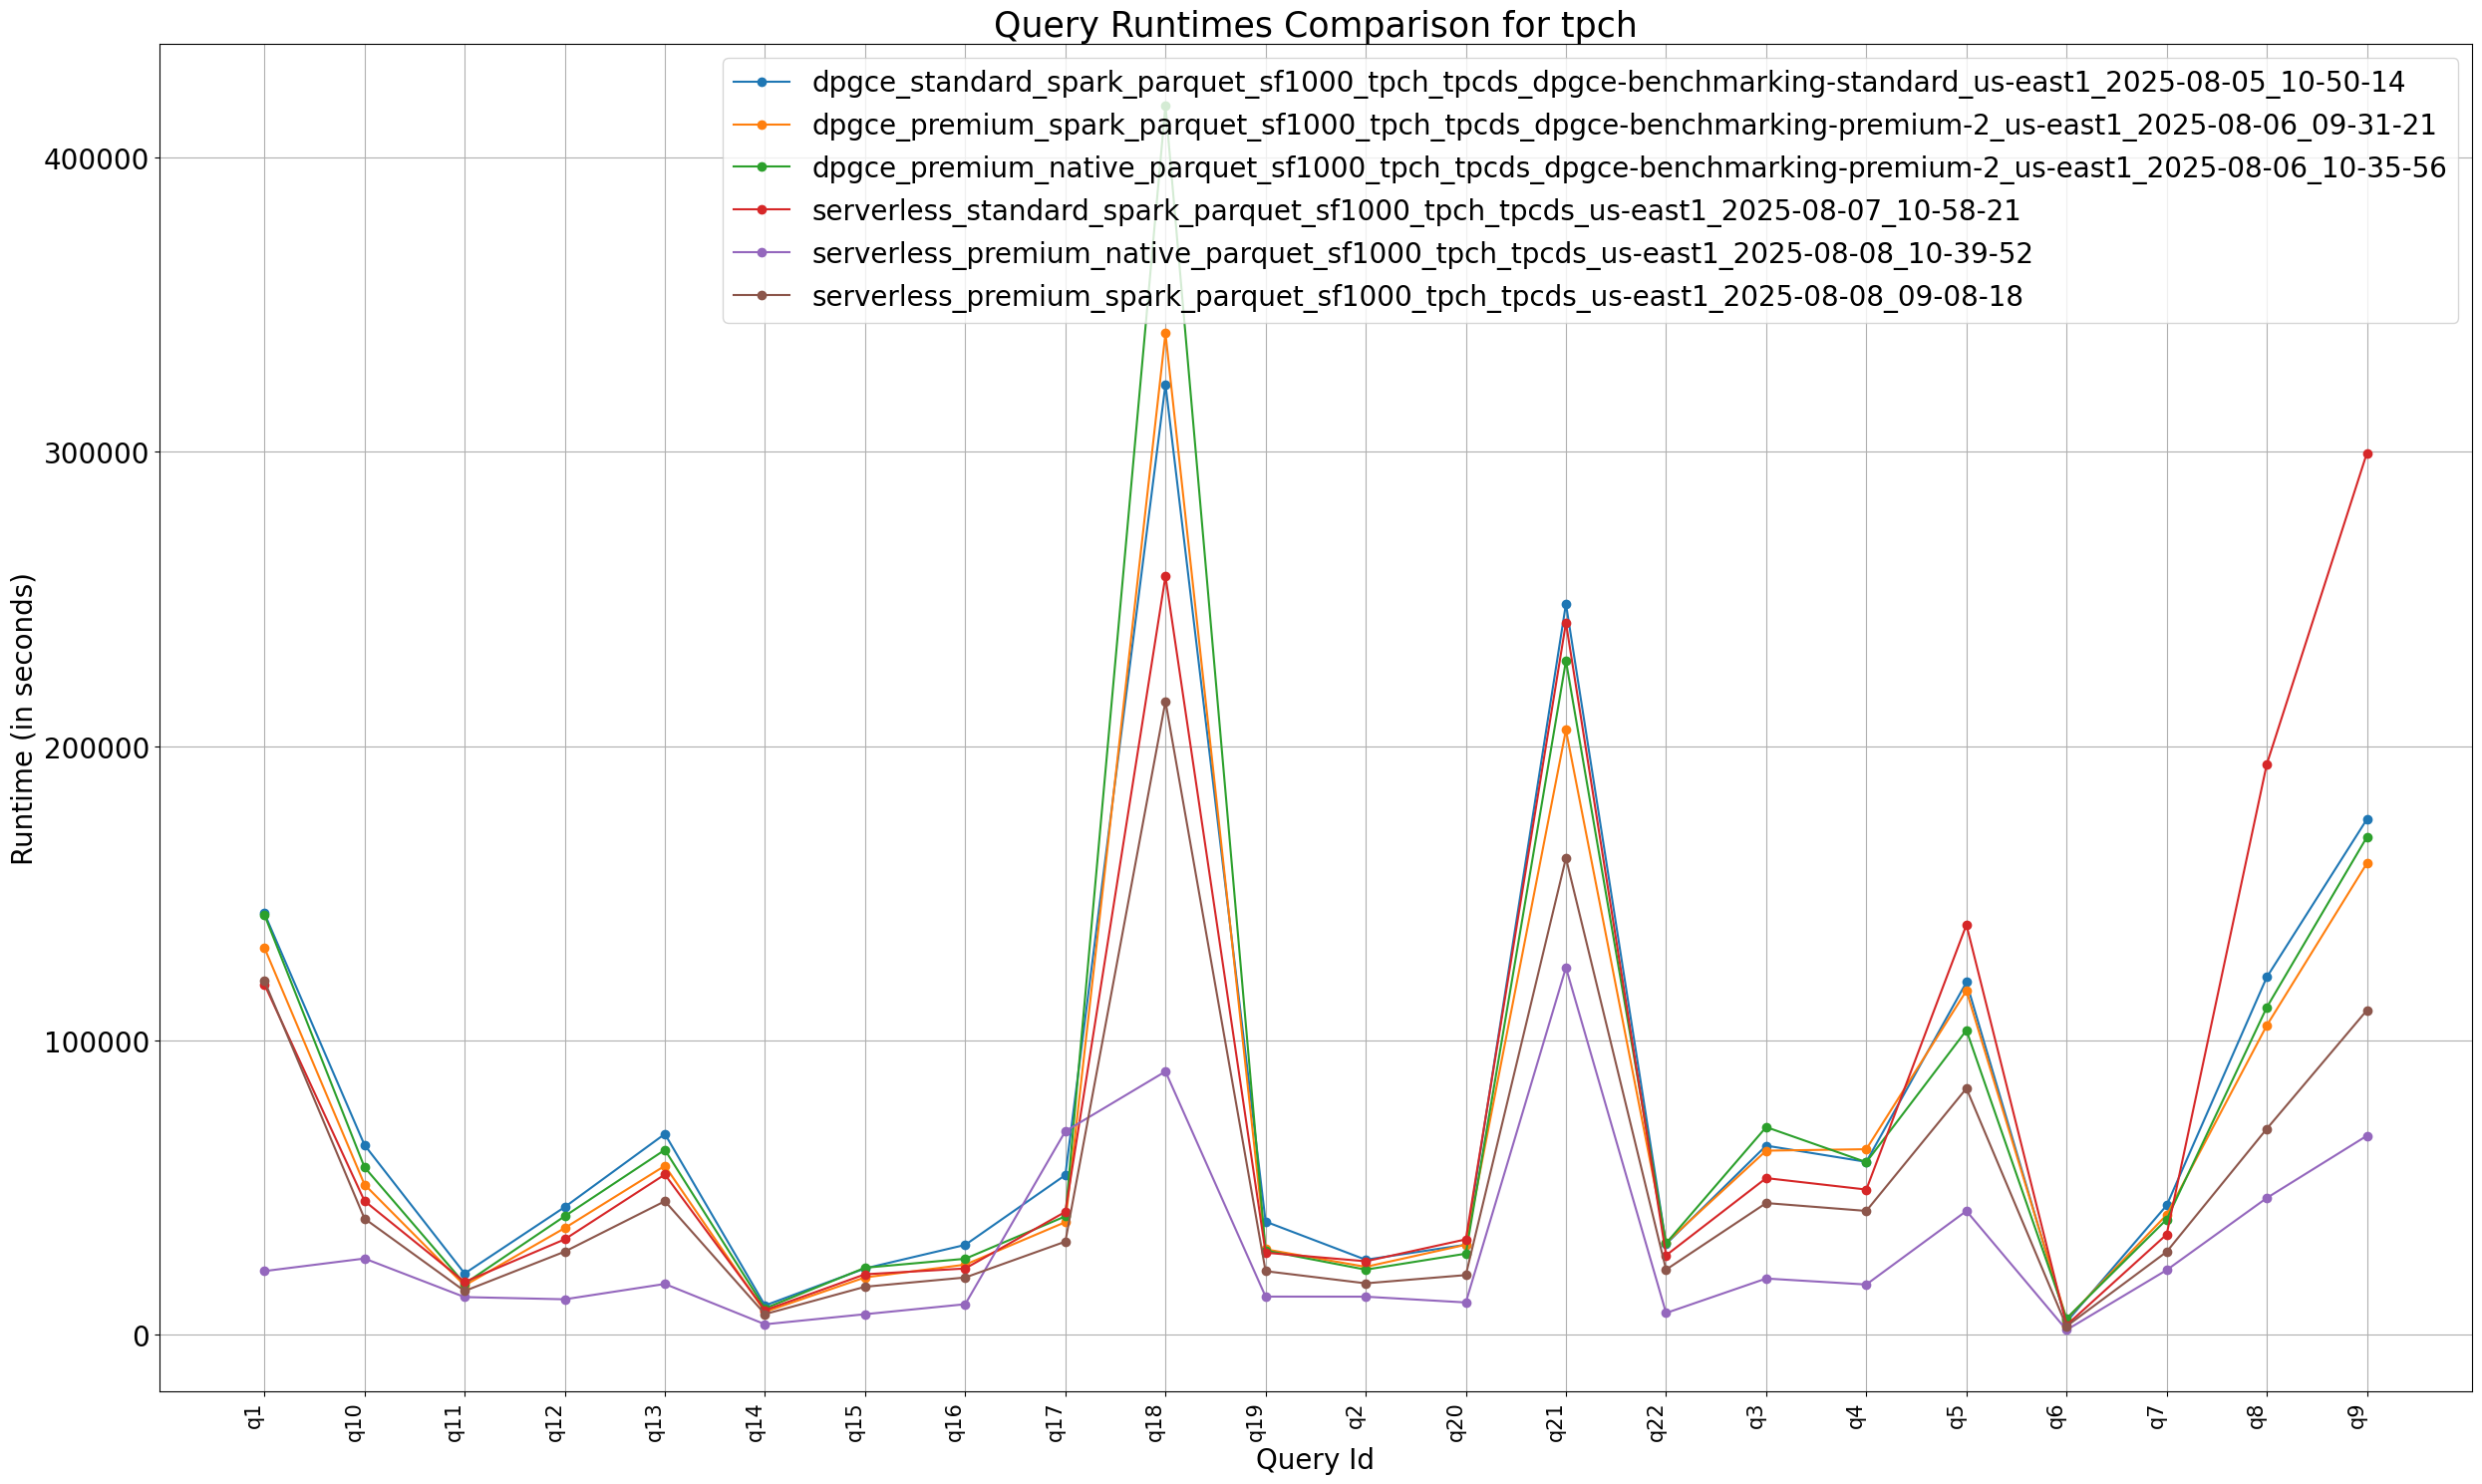

In [8]:
compare_runtimes(comparison_requirements,run_ids,"tpch")

#### TPCDS

  
Reading runtimes from: gs://sparkpoc-bucket-dpgce-standard-279814974066-us-east1/dpgce-benchmarking-standard/standard/spark/output/parquet/tpcds/sf1000/dpgce_standard_spark_parquet_sf1000_tpch_tpcds_dpgce-benchmarking-standard_us-east1_2025-08-05_10-50-14.csv
  
Reading runtimes from: gs://sparkpoc-bucket-dpgce-premium-279814974066-us-east1/dpgce-benchmarking-premium-2/premium/spark/output/parquet/tpcds/sf1000/dpgce_premium_spark_parquet_sf1000_tpch_tpcds_dpgce-benchmarking-premium-2_us-east1_2025-08-06_09-31-21.csv
  
Reading runtimes from: gs://sparkpoc-bucket-dpgce-premium-279814974066-us-east1/dpgce-benchmarking-premium-2/premium/native/output/parquet/tpcds/sf1000/dpgce_premium_native_parquet_sf1000_tpch_tpcds_dpgce-benchmarking-premium-2_us-east1_2025-08-06_10-35-56.csv
  
Reading runtimes from: gs://sparkpoc-bucket-serverless-standard-279814974066-us-east1/standard/spark/output/parquet/tpcds/sf1000/serverless_standard_spark_parquet_sf1000_tpch_tpcds_us-east1_2025-08-07_10-58-2

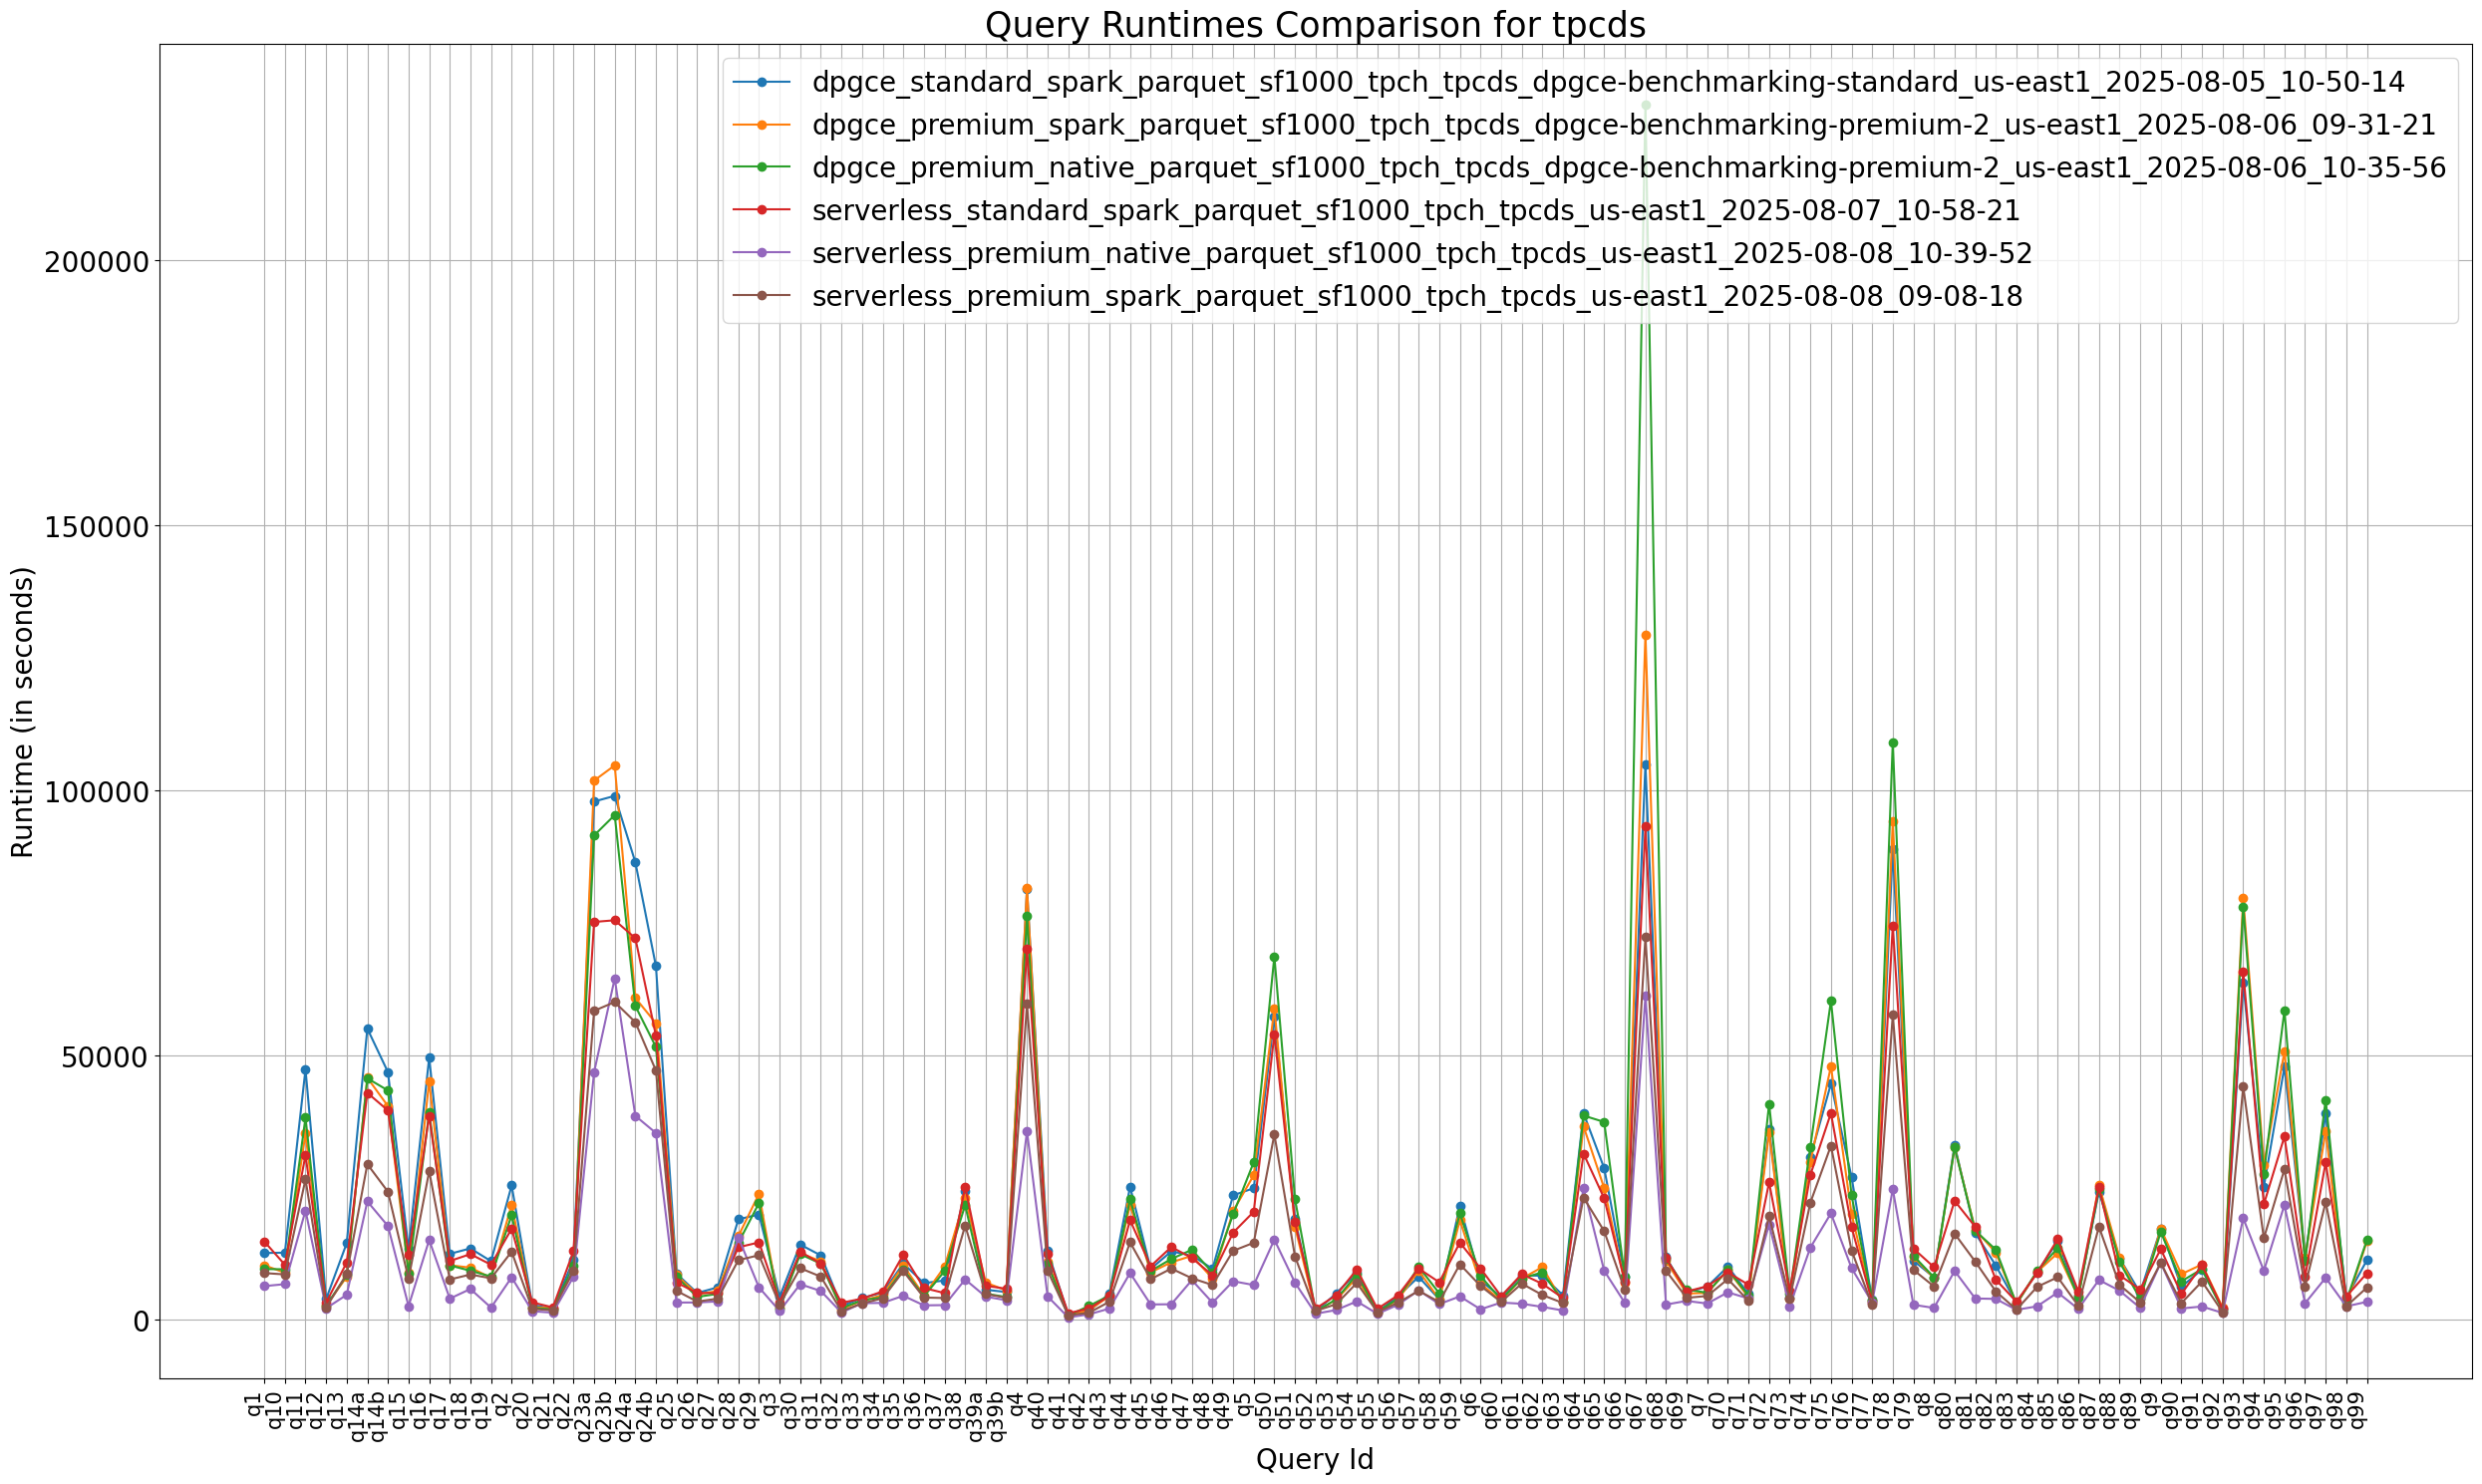

In [9]:
compare_runtimes(comparison_requirements,run_ids,"tpcds")

### Compare Cost Performance

The following cell displays DCU and Shuffle storage usage for all the Serverless runs specified in the list of Run Ids.

In [10]:
compare_cost_metrics(comparison_requirements,run_ids)



Run Id dpgce_standard_spark_parquet_sf1000_tpch_tpcds_dpgce-benchmarking-standard_us-east1_2025-08-05_10-50-14 is a DPGCE run.
Pricing details for DPGCE runs can be checked through : https://cloud.google.com/products/calculator


Run Id dpgce_premium_spark_parquet_sf1000_tpch_tpcds_dpgce-benchmarking-premium-2_us-east1_2025-08-06_09-31-21 is a DPGCE run.
Pricing details for DPGCE runs can be checked through : https://cloud.google.com/products/calculator


Run Id dpgce_premium_native_parquet_sf1000_tpch_tpcds_dpgce-benchmarking-premium-2_us-east1_2025-08-06_10-35-56 is a DPGCE run.
Pricing details for DPGCE runs can be checked through : https://cloud.google.com/products/calculator


----------------------------------------------------------------------------------------------------------------
Cost Metrics for Run Id serverless_standard_spark_parquet_sf1000_tpch_tpcds_us-east1_2025-08-07_10-58-21
-----------------------------------------------------------------------------------------